In [1]:
import cv2
import numpy as np
import imutils
import os
import shutil
from matplotlib import pyplot as plt

In [2]:
cropped_dir_path = os.path.join(os.path.dirname(os.path.realpath("__file__")) , "segments")
sample_images_path = os.path.join(os.path.dirname(os.path.realpath("__file__")) , '..',"sample-images")
print(cropped_dir_path)
print(sample_images_path)

/mnt/c/Users/mahesh.m/Documents/ProjPyWorkspace/line-detect-ht/segments
/mnt/c/Users/mahesh.m/Documents/ProjPyWorkspace/line-detect-ht/../sample-images


In [8]:
image_name = "signed-afs-ey-09.jpg"
img_tru = cv2.imread(sample_images_path +"/" +image_name,0)
img = cv2.imread(sample_images_path +"/" + image_name,0)
sec_image = cv2.imread(sample_images_path+"/" +image_name)

In [9]:
(thresh, img_bin) = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)

In [10]:
# Set figure width to 12 and height to 9
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 19
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size

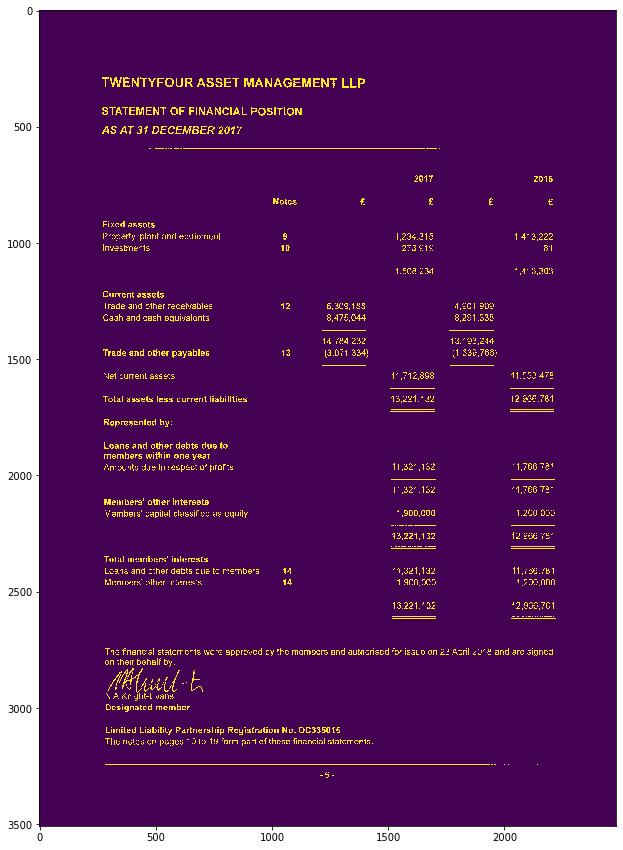

In [11]:
# Invert the image
img_bin = 255-img_bin 
cv2.imwrite("Image_bin.jpg",img_bin)
plt.imshow(img_bin)

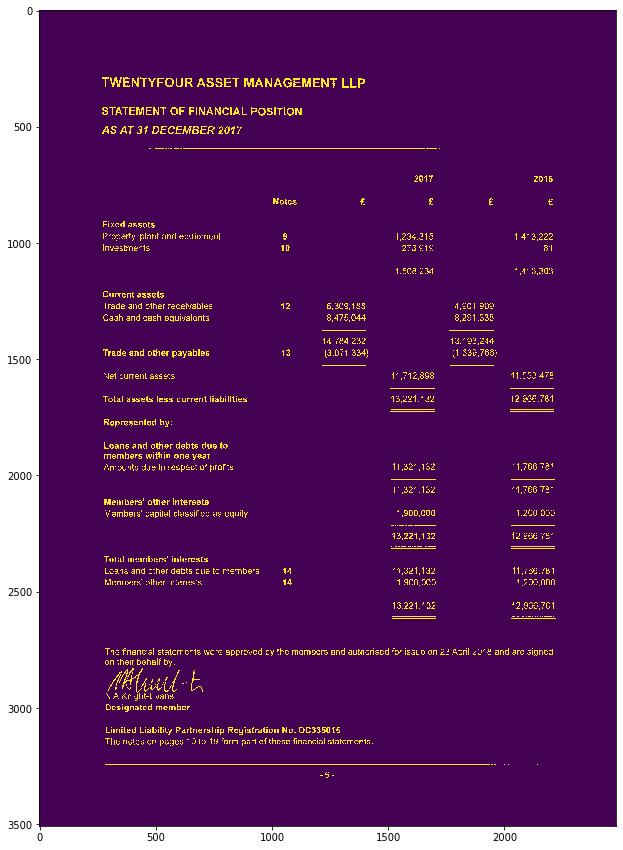

In [12]:
# Find contours for image, which will detect all the boxes
kernel_for_para = cv2.getStructuringElement(cv2.MORPH_CROSS,(1,1))
dilated_paras_img = cv2.dilate(img_bin,kernel_for_para,iterations = 5)
plt.imshow(dilated_paras_img)

True

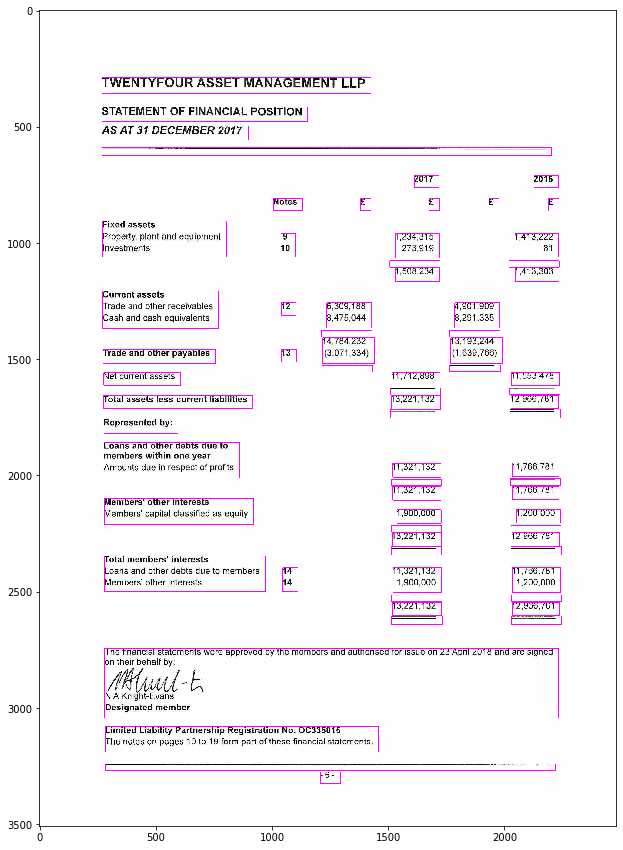

In [13]:

gray_img = cv2.cvtColor(sec_image,cv2.COLOR_BGR2GRAY) # grayscale
_,thresh_img = cv2.threshold(gray_img,150,255,cv2.THRESH_BINARY_INV) # threshold
kernel_rect = cv2.getStructuringElement(cv2.MORPH_CROSS,(2,2))
dilated_img = cv2.dilate(thresh_img,kernel_rect,iterations = 25) # dilate
contours_img, hierarchy_img = cv2.findContours(dilated_img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) # get contours

# for each contour found, draw a rectangle around it on original image
for contour in contours_img:
    # get rectangle bounding contour
    [x,y,w,h] = cv2.boundingRect(contour)
    # discard areas that are too small
    if h<10 or w<10:
        continue
    # draw rectangle around contour on original image
    cv2.rectangle(sec_image,(x,y),(x+w,y+h),(255,0,255),2)

plt.imshow(sec_image)
cv2.imwrite("segmented_page.jpg",sec_image)

In [14]:
# Defining a kernel length
kernel_length = np.array(img).shape[1]//80
kernel_length = 3 
# A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
kernel_length = 4
# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
print(hori_kernel)
print(verticle_kernel)
# A kernel of (3 X 3) ones.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

[[1 1 1 1]]
[[1]
 [1]
 [1]]


In [15]:
# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=5)
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=5)
cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
# Morphological operation to detect horizontal lines from an image
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=5)
horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=5)
cv2.imwrite("horizontal_lines.jpg",horizontal_lines_img)

True

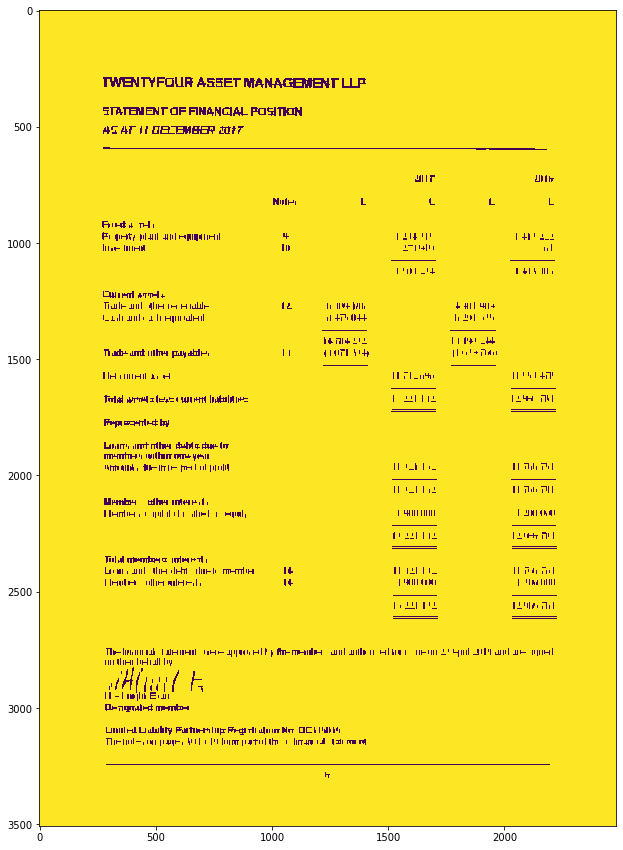

In [16]:
# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha
# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=1)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("img_final_bin.jpg",img_final_bin)
plt.imshow(img_final_bin)

In [17]:
def sort_contours(cnts, method="left-to-right"):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
 
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
 
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
 
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
 
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

In [18]:
# Find contours for image, which will detect all the boxes
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Sort all the contours by top to bottom.
(contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

In [19]:
idx = 0
print("about to remove all files from "+cropped_dir_path)
shutil.rmtree(cropped_dir_path)
os.mkdir(cropped_dir_path)

#print(str(c.size))
#print(boundingBoxes)
for c in contours:
       # Returns the location and width,height for every contour
        x, y, w, h = cv2.boundingRect(c)
        if (w > 80 and h > 20) and w > 3*h:
            idx += 1
            new_img = img_tru[y:y+h, x:x+w]
            cv2.imwrite(cropped_dir_path+"/"+str(idx) + '.png', new_img)

about to remove all files from /mnt/c/Users/mahesh.m/Documents/ProjPyWorkspace/line-detect-ht/segments
